# Graph construction from text
### Source: https://github.com/majiga/Text2Graph

This file performs following tasks:
1. extracts entities
2. extracts word-level relations between the entities
3. constructs a graph

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 21 15:30:40 2019

@author: Majigsuren Enkhsaikhan
"""
import os
import csv
import pandas as pd
import re
import json
import spacy
from spacy import displacy
from spacy.pipeline import EntityRuler
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span, Token
from spacy.attrs import intify_attrs
nlp = spacy.load("en_core_web_sm")

import networkx as nx
import matplotlib.pyplot as plt

abspath = os.path.abspath('') ## String which contains absolute path to the script file
os.chdir(abspath)

### ==================================================================================================
# Tagger
def filter_spans(spans):
    # Filter a sequence of spans so they don't contain overlaps
    get_sort_key = lambda span: (span.end - span.start, span.start)
    sorted_spans = sorted(spans, key=get_sort_key, reverse=True)
    result = []
    seen_tokens = set()
    for span in sorted_spans:
        if span.start not in seen_tokens and span.end - 1 not in seen_tokens:
            result.append(span)
            seen_tokens.update(range(span.start, span.end))
    return result

# for entities
def tag_noun_chunks(doc):
    # entities
    spans = list(doc.ents)
    spans = filter_spans(spans)
    with doc.retokenize() as retokenizer:
        string_store = doc.vocab.strings
        for span in spans:
            start = span.start
            end = span.end            
            #retokenizer.merge(doc[start: end], attrs=intify_attrs({'ent_type': 'NOUN_CHUNK'}, string_store))
            retokenizer.merge(span)
    
# for verbs
def tag_chunks_spans(doc, spans, span_type):
    spans = filter_spans(spans)
    with doc.retokenize() as retokenizer:
        string_store = doc.vocab.strings
        for span in spans:
            start = span.start
            end = span.end
            retokenizer.merge(doc[start: end], attrs=intify_attrs({'ent_type': span_type}, string_store))
            #retokenizer.merge(doc[start: end])

def clean(text):
    text = text.strip('[(),- :\'\"\n]\s*').lower()
    #text = re.sub('([A-Za-z0-9\)]{2,}\.)([A-Z]+[a-z]*)', r"\g<1> \g<2>", text, flags=re.UNICODE)
    text = re.sub('\s+', ' ', text, flags=re.UNICODE).strip()
    text = re.sub('","', ' ', text, flags=re.UNICODE).strip()
    text = re.sub('-', ' ', text, flags=re.UNICODE).strip()
    #text = re.sub('\(', ' ', text, flags=re.UNICODE).strip()
    #text = re.sub('\)', ' ', text, flags=re.UNICODE).strip()
    text = re.sub('\/', ' ', text, flags=re.UNICODE).strip()
    text = text.replace("\\", ' ')
        
    text = ' '.join(text.split())
    
    if (text[len(text)-1] != '.'):
        text += '.'
    return text

def tagger(text):  
    df_out = pd.DataFrame(columns=['Document#', 'Sentence#', 'Word#', 'Word', 'EntityType', 'EntityIOB', 'Lemma', 'POS', 'POSTag', 'Start', 'End', 'Dependency'])
    #corefs = []
    text = clean(text)
    
    nlp = spacy.load("en_core_web_sm")
    ruler = EntityRuler(nlp, overwrite_ents=True)
    
    # Read JSON file
    with open('VOCABULARY_TYPED.json', encoding="utf8") as data_file:
        patterns = json.load(data_file)

    ruler.add_patterns(patterns)
    nlp.add_pipe(ruler)

    document = nlp(text)
    
    annotation = []
    #print('Spacy NLP before chunking \n')
    for token in document:
        #print(token.text, token.ent_type_)
        if token.ent_type_ in ['ORE_DEPOSIT', 'ROCK', 'MINERAL', 'STRAT', 'LOCATION', 'TIMESCALE']:
        #print([token.i, token.text, token.ent_type_, token.ent_iob_, token.lemma_, token.pos_, token.tag_, token.idx, token.idx+len(token)-1, token.dep_])
            annotation.append([token.text, token.ent_iob_ + '-' + token.ent_type_]) #, token.pos_, token.tag_]) 
            #print(token.text, token.ent_iob_ + '-' + token.ent_type_)
        else:
            annotation.append([token.text, 'O'])
            #print(token.text, 'O')
    #print('\n\n\n')
    
    # Chunk entities
    tag_noun_chunks(document)    
    
    # Chunk verbs with multiple words: 'were exhibited'
    spans_change_verbs = []
    for i in range(1, len(document)):
        w_left = document[i-1]
        w_right = document[i]
        if w_left.pos_ == 'VERB' and w_right.pos_ == 'VERB' and w_left.ent_type_ != 'NOUN_CHUNK' and w_right.ent_type_ != 'NOUN_CHUNK':
            spans_change_verbs.append(document[w_left.i : w_right.i + 1])
    tag_chunks_spans(document, spans_change_verbs, 'VERB_CHUNK')

    # Chunk verbs
    spans_change_verbs = []
    for i in range(2, len(document)):
        w_left = document[i-2]
        w_middle = document[i-1]
        w_right = document[i]
        if w_left.ent_type_ == 'ADP' and w_middle.ent_type_ == 'VERB' and w_right.ent_type_ == 'ADP' and w_left.ent_type_ != 'NOUN_CHUNK' and w_middle.ent_type_ != 'NOUN_CHUNK' and w_right.ent_type_ != 'NOUN_CHUNK':
            spans_change_verbs.append(document[w_left.i : w_right.i + 1])
    tag_chunks_spans(document, spans_change_verbs, 'VERB_CHUNK')

    # Chunk verbs
    spans_change_verbs = []
    for i in range(2, len(document)):
        w_left = document[i-2]
        w_middle = document[i-1]
        w_right = document[i]
        if w_left.ent_type_ == 'VERB' and w_middle.ent_type_ == 'PART' and w_right.ent_type_ == 'ADP' and w_left.ent_type_ != 'NOUN_CHUNK' and w_middle.ent_type_ != 'NOUN_CHUNK' and w_right.ent_type_ != 'NOUN_CHUNK':
            spans_change_verbs.append(document[w_left.i : w_right.i + 1])
    tag_chunks_spans(document, spans_change_verbs, 'VERB_CHUNK')

    # Chunk: adp + verb; part  + verb
    spans_change_verbs = []
    for i in range(1, len(document)):
        w_left = document[i-1]
        w_right = document[i]
        if w_right.pos_ == 'VERB' and (w_left.pos_ == 'ADP' or w_left.pos_ == 'PART')  and w_left.ent_type_ != 'NOUN_CHUNK' and w_right.ent_type_ != 'NOUN_CHUNK':
            spans_change_verbs.append(document[w_left.i : w_right.i + 1])
    tag_chunks_spans(document, spans_change_verbs, 'VERB_CHUNK')

    # Chunk: verb + adp; verb + part 
    spans_change_verbs = []
    for i in range(1, len(document)):
        w_left = document[i-1]
        w_right = document[i]
        if w_left.pos_ == 'VERB' and (w_right.pos_ == 'ADP' or w_right.pos_ == 'PART')  and w_left.ent_type_ != 'NOUN_CHUNK' and w_right.ent_type_ != 'NOUN_CHUNK':
            spans_change_verbs.append(document[w_left.i : w_right.i + 1])
    tag_chunks_spans(document, spans_change_verbs, 'VERB_CHUNK')

    # Chunk verbs with multiple words: 'were exhibited'
    spans_change_verbs = []
    for i in range(1, len(document)):
        w_left = document[i-1]
        w_right = document[i]
        if w_left.pos_ == 'VERB' and (w_right.pos_ == 'VERB') and w_left.ent_type_ != 'NOUN_CHUNK' and w_right.ent_type_ != 'NOUN_CHUNK':
            spans_change_verbs.append(document[w_left.i : w_right.i + 1])
    tag_chunks_spans(document, spans_change_verbs, 'VERB_CHUNK')

    for i in range(1, len(document)):
        w_single_verb = document[i]
        if w_single_verb.pos_ == 'VERB' and w_single_verb.ent_type_ == '':
            spans_change_verbs.append(document[w_single_verb.i : w_single_verb.i + 1])
    tag_chunks_spans(document, spans_change_verbs, 'VERB_CHUNK')

    # chunk all between LRB- -RRB- (something between brackets)
    start = 0
    end = 0
    spans_between_brackets = []
    for i in range(0, len(document)):
        if ('-LRB-' == document[i].tag_ or r"(" in document[i].text):
            start = document[i].i
            continue
        if ('-RRB-' == document[i].tag_ or r')' in document[i].text):
            end = document[i].i + 1
        if (end > start and not start == 0):
            span = document[start:end]
            try:
                assert (u"(" in span.text and u")" in span.text)
            except:
                pass
                #print(span)
            spans_between_brackets.append(span)
            start = 0
            end = 0
    tag_chunks_spans(document, spans_between_brackets, '')
    
    ignore_entities = ['drill', 'ltd', 'limited', 'pty', 'company', 'project', 'prospect', 'hole', 'twin', 'impregnate', 'core']
    noun_chunks = []
    doc_id = 0
    count_sentences = 0
    #print("Some Rules to ignore some entities are performed.\n\n")
    for token in document:
        #print(len(document), token.i)
        if (token.text == '.'):
            count_sentences += 1
        elif (token.ent_type_ != '' and token.ent_type_ != 'VERB_CHUNK'):
            noun_chunks.append(token)
        if token.tag_ == 'CD' or token.ent_type_ == 'CARDINAL' or token.ent_type_ == 'QUANTITY':
            #print(token, token.tag_)
            df_out.loc[len(df_out)] = [doc_id, count_sentences, token.i, token.text, '', '', token.lemma_, token.pos_, token.tag_, token.idx, token.idx+len(token)-1, token.dep_]
        elif (len(document) > token.i + 1):
            #print(token.text, token.i, doc[token.i+1].text, token.i + 1)            
            if (bool([w for w in ignore_entities if(w in document[token.i+1].text)])):
                df_out.loc[len(df_out)] = [doc_id, count_sentences, token.i, token.text, '', '', token.lemma_, token.pos_, token.tag_, token.idx, token.idx+len(token)-1, token.dep_]
            else:
                df_out.loc[len(df_out)] = [doc_id, count_sentences, token.i, token.text, token.ent_type_, token.ent_iob_, token.lemma_, token.pos_, token.tag_, token.idx, token.idx+len(token)-1, token.dep_]
        else:
            df_out.loc[len(df_out)] = [doc_id, count_sentences, token.i, token.text, token.ent_type_, token.ent_iob_, token.lemma_, token.pos_, token.tag_, token.idx, token.idx+len(token)-1, token.dep_]
    
    #print("ENTS\n", len(document.ents), '\n', document.ents, '\n\n')
    
    return df_out, document.ents, document, annotation #, words_ids #noun_chunks

### ==================================================================================================
### triple extractor

def get_sentences(df_text):
    sentences = []
    aSentence = []
    
    for index, row in df_text.iterrows():
        d_id, s_id, word_id, word, ent, ent_iob, lemma, cg_pos, pos, start, end, dep = row.items()
        
        #if 'VERB_CHUNK' == ent[1] or (('ADP' in cg_pos[1] or 'VERB' in cg_pos[1]) and ent[1] == ''):
        if 'VERB_CHUNK' == ent[1] or (('ADP' in cg_pos[1] or 'VERB' in cg_pos[1]) and ent[1] == ''):
            aSentence.append([word[1], word_id[1], 'VERB_CHUNK'])
        #elif 'obj' in dep[1]:
        #    aSentence.append([word[1], word_id[1], 'object'])
        elif ent[1] != '' and ent[1] != 'VERB_CHUNK':
            aSentence.append([word[1], word_id[1], ent[1]]) # 'NOUN_CHUNK'
        elif word[1] == '.':
            aSentence.append([word[1], word_id[1], '.'])
            sentences.append(aSentence)
            aSentence = []
        else:
            #aSentence.append([word[1], word_id[1], pos[1]])    
            aSentence.append([word[1], word_id[1], ''])
    
    #print('\n', sentences, '\n')
    return sentences

def get_predicate(s):
    pred_ids = {}
    for w, index, spo in s:
        #print(s)
        if spo == 'VERB_CHUNK' and w != "'s":
            pred_ids[index] = w
    predicates = {}
    for key, value in pred_ids.items():
        predicates[key] = value
    #print(predicates)
    return predicates

def get_positions(s, start, end):
    adps = {}
    #print(start, end)
    for w, index, spo in s:
        #print(w, index, spo)
        if index >= start and index <= end and not (spo == '' or spo == '.' or spo == 'VERB_CHUNK'):
            #print(index)
            adps[index] = w
    #print('adps = ', adps, '\n')
    return adps

### ==================================================================================================
def extract_sentence_triples(df_text):
    sentences = get_sentences(df_text)
    sentence_relations = {}
    #count = 0
    # FOR EACH SENTENCE
    for s in sentences:
        if len(s) == 0: 
            continue
        
        relations = []
        preds = get_predicate(s) # Get all verbs
        #print("\nPreds = ", preds, '\n')
        
        raw_sent = ' '.join(list(zip(*s))[0]) # get the raw sentence
        #print(raw_sent, '\n')
        if preds:
            if (len(preds) == 1):
                #print("preds = ", preds)
                predicate = list(preds.values())[0]
                #print("predicate = ", predicate)
                #if (len(predicate) < 2):
                #    predicate = 'is'
                #print(s)
                ents = [e[0] for e in s if e[2] != '' and e[2] != '.' and e[2] != 'VERB_CHUNK']
                #print('ents = ', ents)
                for i in range(1, len(ents)):
                    relations.append([ents[0], predicate, ents[i]])
                    #print('1 - ', relations, '\n')

            pred_ids = list(preds.keys())
            pred_ids.append(s[0][1])
            pred_ids.append(s[len(s)-1][1])
            pred_ids.sort()
                    
            for i in range(1, len(pred_ids)-1):                
                predicate = preds[pred_ids[i]]
                #print('---- predicate = ', predicate)
                
                adps_subjs = get_positions(s, pred_ids[i-1], pred_ids[i])
                #print('- subjects = ', adps_subjs)
                adps_objs = get_positions(s, pred_ids[i], pred_ids[i+1])
                #print('- objects = ', adps_objs)
                
                for k_s, subj in adps_subjs.items():                
                    for k_o, obj in adps_objs.items():
                        obj_prev_id = int(k_o) - 1
                        if obj_prev_id in adps_objs: # at, in, of
                            #relations.append([subj, predicate + ' ' + adps_objs[obj_prev_id], obj, raw_sent])
                            relations.append([subj, predicate, obj])
                            #print('2 - ', relations, '\n')
                        else:
                            relations.append([subj, predicate, obj])
                            #print('3 - ', relations, '\n')
        sentence_relations[raw_sent] = relations
        #count += 1
        
    #print("RELATIONS by Sentence\n", sentence_relations)
    return sentence_relations
       
def extract_triples_by_sentences(text):
    remove_words = ['a', 'an', 'the', 'its', 'their', 'his', 'her', 'our', 'who', 'that', 'this', 'these', 'those']
    df_tagged, entities, doc, annotation = tagger(text)
    
    #extract_relations(doc)    
    sentence_triples = extract_sentence_triples(df_tagged)
    
    Sent_Triples = {}
    for raw_sentence, triples in sentence_triples.items():        
        filtered_triples = []
        for s, p, o in triples:
            if s == o:
                continue            
            subj = s.strip('[,- :\'\"\n]*')
            pred = p.strip('[- :\'\"\n]*.')
            obj = o.strip('[,- :\'\"\n]*')
            
            subj = ' '.join(word for word in subj.lower().split() if not word in remove_words)
            obj = ' '.join(word for word in obj.lower().split()  if not word in remove_words)
            subj = re.sub("\s\s+", " ", subj)
            obj = re.sub("\s\s+", " ", obj)
            
            if subj and pred and obj:
                filtered_triples.append([subj, pred, obj])
        Sent_Triples[raw_sentence] = filtered_triples

    Sent_Entities = []
    
    #print('\nENTITIES:\n')
    for e in set(entities):
        entity = ' '.join(word for word in e.text.lower().split() if not word in remove_words)
        Sent_Entities.append(entity)
    
    return Sent_Triples, df_tagged, entities, doc, annotation # Sent_Entities

def get_graph(triples):
    G = nx.DiGraph()
    for s, p, o in triples:
        G.add_edge(s, o, label=p)
    return G

def draw_graph_centrality(G):    
    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')
    
    plt.figure(figsize=(15,8))
    pos = nx.spring_layout(G)
    #print("Nodes\n", G.nodes(True))
    #print("Edges\n", G.edges())
    nx.draw_networkx_nodes(G, pos, 
            nodelist=degree_dict.keys(),
            with_labels=False,
            edge_color='black',
            width=1,
            linewidths=1,
            node_size = [v * 100 for v in degree_dict.values()],
            node_color='blue',
            alpha=0.3)
    edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
    #print(edge_labels)
    nx.draw_networkx_edge_labels(G, pos,
                           font_size=9,
                           edge_labels=edge_labels,
                           font_color='red')
    nx.draw(G, pos, with_labels=True, node_size=1, node_color='blue')

def draw_graph(G):
    plt.figure(figsize=(12,10))
    pos = nx.spring_layout(G)
    #print("Nodes\n", G.nodes(True))
    #print("Edges\n", G.edges())
    
    edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
    #print(edge_labels)
    nx.draw_networkx_edge_labels(G, pos,
                           font_size=10,
                           edge_labels=edge_labels,
                           font_color='blue')
    nx.draw(G, pos, with_labels=True, node_size=4, node_color='blue')

# Synonyms and Abbreviations are siolved using a list in synonyms.csv file

def resolve_synonyms(g):
    synonyms = {}
    with open("synonyms.csv", 'r', encoding='latin1') as f:        
        reader = csv.reader(f, delimiter=',')
        for row in reader:            
            synonyms[row[0].lower()] = row[1].lower() # abbreviation and exact words
    #print('synonyms # : ', synonyms)
    
    remove_nodes = []
    add_edges = []
    add_nodes = []

    #print('Resolve synonym before:\n', nx.info(g))

    for s, t, data in g.edges(data=True):
        #if s not in remove_nodes:
            if s in synonyms.keys():
                if synonyms[s] not in g.nodes():
                    add_nodes.append([synonyms[s], g.node[s]])
                add_edges.append([synonyms[s], t, data['label']])
                #print('add_edge: ', [synonyms[s], t, data['label']])
                if s not in remove_nodes:
                    remove_nodes.append(s)
        #if t not in remove_nodes:
            if t in synonyms.keys():
                if synonyms[t] not in g.nodes():
                    add_nodes.append([synonyms[t], g.node[t]])
                add_edges.append([s, synonyms[t], data['label']])
                #print('add_edge: ', [s, synonyms[t], data['label']])
                if t not in remove_nodes:
                    remove_nodes.append(t)
    
    # deal with unconnected nodes
    for n, data in g.nodes(data=True):
        if n not in remove_nodes:
            if n in synonyms.keys():
                if synonyms[n] not in g.nodes():
                    add_nodes.append([synonyms[n], g.node[n]])
                remove_nodes.append(n)
                
    for n, data in add_nodes:
        #print('add node: ', n, data)
        g.add_node(n, group=data['group'])
    
    for s, t, d in add_edges:
        #print('add egde: ', s, t, d)
        g.add_edge(s, t, label=d)
    
    if len(remove_nodes) > 0:
        #print('Synonyms are found. Remove nodes : ', remove_nodes)
        for n in remove_nodes: # remove the merged nodes
            if n in g.nodes():
                g.remove_node(n)
    
    #print('Resolve synonym after:\n', nx.info(g))
    return g    

def build_graphs(triples, entities):
    G = nx.DiGraph()
    ents = {e.text: e.label_ for e in entities}
    
    for s, p, o in triples:
        #print(s, p, o)
        # create a node
        if (s not in G.nodes()):
            #print('\n\n', ents[o])
            G.add_node(s, group=ents[s])
        if (o not in G.nodes()):
            G.add_node(o, group=ents[o])
        #print(s, p, o)
        if G.has_edge(s, o):
            current_labels = G[s][o]['label'].split(',')
            #print(current_labels)
            if p.strip() not in current_labels:
                G.add_edge(s, o, label=G[s][o]['label'] + ',' + p)
        else:
            G.add_edge(s, o, label=p)
    
    #print(G.nodes(True))
    return G, ents

# Create a graph file from a given graph
def create_graph_file(g, filename):
    # Add degree
    degree_dict = dict(g.degree(g.nodes()))
    nx.set_node_attributes(g, degree_dict, 'degree')

    # Save graph files
    nodes = [{'id': n, 'group': g.node[n]['group'], 'degree': g.node[n]['degree']} for n in g.nodes()]
    links = [{'source': u, 'target': v, 'label': d['label']} for u, v, d in g.edges(data=True)]
    with open(filename, 'w') as f:
        json.dump({'nodes': nodes, 'links': links}, f, indent=4,)

In [4]:
def text2graph(text):
    Sent_Triples, df, entities, doc, annotation = extract_triples_by_sentences(text)
    """
    for index, row in df.iterrows():
        _, s, i, w, ent, iob, l, pos, tag, s, e, dep = row
        print(i, '\t', w, '\t', ent, '\t', s, '\t', e)
    """
   
    #print("\n\nEntities:", len(entities), "\n")
    #for e in entities:
    #    print(e, e.label_, e.start, e.end)
        
    triples = []
    #print('\n\nSentence # = ', len(Sent_Triples))
    for k,v in Sent_Triples.items():
        #print('\n', k)
        triples += v
        #for val in v:
        #    print(val)        
    #print("Triples\n", len(triples))
    
    g, ents = build_graphs(triples, entities)    
    
    #print("\n------ SYNONYMS resolving on the graph ... ")
    M = resolve_synonyms(g)
    
    #print("\n------ SELF LOOP removal on the graph ... \n")
    M.remove_edges_from(M.selfloop_edges())    
    
    return M, annotation, doc

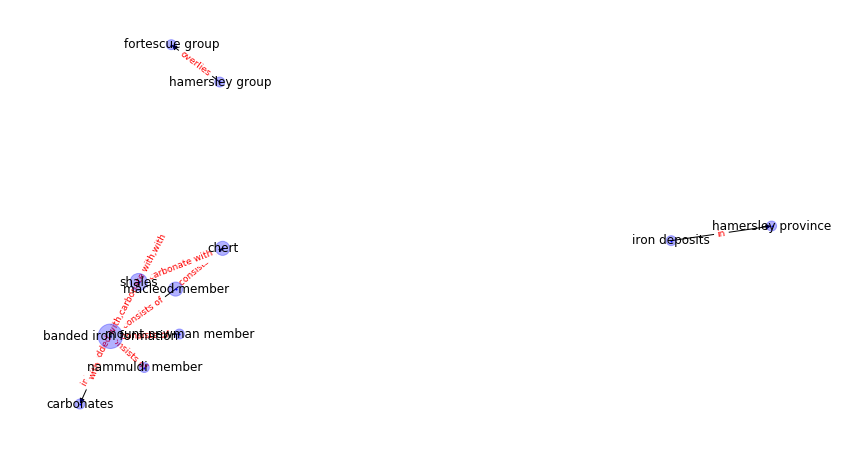

In [6]:
# a075345_c125_2004_2007a_14419765.json
text = """The Hamersley Group (approximately 2450-2630 Ma) conformably overlies the Fortescue Group and is about 2,500m thick.
The Hamersley Group consists of a sequence of banded iron formations (BIF), dolomites, pyroclastic\/hemipelagic shale, and acid volcanic rocks and has been intruded by dolerite sills and dykes.
The MMIF, particularly in its upper section, is host to major iron deposits in the Hamersley Province.
The formation consists of 3 members: The lowermost Nammuldi Member (~80m thick) consists of cherty BIF interbedded with thin shales.
The MacLeod Member (~75m thick) consists of BIF, chert and carbonate with numerous interbedded shales and several prominent podded BIF horizons which provide marker horizons invaluable in field mapping.
The upper Mount Newman Member (~65m thick) consists of more typical BIF with interbedded carbonates and shales."""

# a072391_c125_2004_2006a_12728776.json
"The Nammuldi Member within the exploration area is characterised by extensive\/thick and podded iron rich Banded Iron Formation (BIF), separated by equally extensive units of siliceous and carbonate rich chert and shale. Underlying the Nammuldi Member rocks are black shales and volcanic rocks belonging to the Jeerinah Formation. The other volcanic rocks are found in the Jeerinah Formation."

"""Iron enrichment in the Pincunah Hills Formation is found at 'all stratigraphic levels in the formation and forms irregular pods with a distinct orientation to the bedding of the BIF."""
#text = """The Mt Webber Project and surrounding area has been explored for various commodities (Cu Pb Ni Zn) since late in the nineteenth century.","Exploration has primarily focused on the greenstone belts and has produced a number of gold and base metal deposits.","Within the Shaw Batholith are numerous mining centres, which constitute the Shaw River tin field.","This field was historically one of the Pilbaras largest producers of tin and tantalum (Crossing, 2008).","Throughout the twentieth century companies have been actively exploring for iron deposits with varying success.","Mt Webber has three areas of iron enrichment that occur in the synclinal fold closures where the Pincunah Hills Formation BIFs are thickened up by extensive intraformational folding.","The largest areas of high-grade enrichment occur on the westernmost (Ibanez) and easternmost synclines.","The latter is divided into two zones, Fender and Gibson, which are separated by a low-grade neck.","Gibson extends off the tenement to the northeast and is part of a resource which has been defined by Giralia.","Both Ibanez and Fender are striking in a NE direction; Ibanez is the larger of the two named deposits with a strike length of 900m and varying widths from 20m at its southernmost tip to 600m within the centre of the deposit.","Fenders strike length is 1.4 km with a strike width averaging 100m throughout and is currently open to the NE.","Iron enrichment is predominantly goethite which has replaced chert in the BIF to varying degrees.","Judging by appearance of a purple colour and the elevated iron grades there is also the presence of hematitic shale.","The iron enrichment outcrops as irregular pods in the BIF where the chert in the BIF has been replaced leaving the enriched zone depleted in quartz.","Areas where enrichment is not outcropping tend to be zones of ferruginous grit or pisolitic and nodular laterite.","This layer is indicative of Mesozoic to Cainozoic weathering that would have contributed to the formation of the iron enrichment pods and is generally 1 to 3m thick.","The enrichment pods are thought to be remnants of an ancient weathering horizon, the pods forming as a result of supergene enrichment of iron in the BIF during the weathering process.","The edges of the enrichment pods are moderately sharp, less than 2-5m wide.","Depths of enrichment are generally 30m but can be as much as 60m as seen in the eastern side of the Ibanez deposit.","The iron enrichment at the surface is generally in the 55 to 60% range but some values in excess of 60% have been encountered.","A hydrated cap of approximately 1 to 10m is present and this is demonstrated in the elevated silica values of plus 10%.","MT WEBBER PROJECT E45\/2312-I FINAL SURRENDER REPORT Page 11 of 20","Review of the results of all of the exploration data and activities failed to identify any further potential for significant iron mineralisation within E45\/2312 I and thus the tenure was recommended for surrender.","MT WEBBER PROJECT E45\/2312-I FINAL SURRENDER REPORT Page 17 of 20","List of Tables Table 1: Tenement Status as at 11 December 2015 .","7 Table 2: Stratigraphy of Pilbara Supergroup, East Pilbara (after Van Kranendonk, 2003) .","10 Table 3: Significant Intercepts from MW08 Prospect RC drilling 2011 .","The tenement covers a portion of Pastoral Lease 3114\/1265, Hillside.","Access to the tenement is via the Great Northern Highway and thence via tracks along the Hillside Woodstock Road and various station tracks.","Geology: The greater Mt Webber Project occupies a portion of the Eastern Pilbara Block of WA and falls predominantly within the Gorge Creek and Sulphur Springs Groups of the Pilbara Supergroup, although the large tenement area includes Fortescue, De Grey and Warrawoona Group rocks.","It overlies three greenstone belts and the Emerald Mine Greenstone Complex (Van Kranendonk, 1998).","Currently the defined resources sit in the eastern side of the Emerald Mine Greenstone Complex.","MT WEBBER PROJECT E45\/2312-I FINAL SURRENDER REPORT Page 5 of 20 MT WEBBER PROJECT E45\/2312-I FINAL SURRENDER REPORT Page 6 of 20 MT WEBBER PROJECT E45\/2312-I FINAL SURRENDER REPORT Page 7 of 20","The tenements form part of Atlas Mt Webber Project and are located approximately 150 km southeast of Port Hedland (Figure 2), in the East Pilbara Shire of Western Australia.","The tenement covers a portion of Pastoral Lease 3114\/1265, Hillside.","The tenements are situated in the Pilbara Block of Western Australia on the Marble Bar SF50-8 1:250K; and Tambourah 2754 1:100K geological map sheets respectively.","Access to the project is via the Great Northern Highway and thence via tracks along the Hillside Woodstock Road and various station tracks.","On 15th January 2008 Atlas Iron Limited announced an option over iron ore rights for a package of tenements held by Haddington Resources (now Altura Exploration Pty Ltd).","Exploration Licence E45\/2312 formed part of this tenement package.","Exploration licence E45\/2312, originally of twenty-seven (27) blocks was granted to Australian Tantalum Ltd (Altura) on 29 September 2006.","The first statutory partial surrender of fourteen (14) blocks and a subsequent partial surrender of six (6) blocks was effected on E45\/2312 in March 2010 and September 2010 respectively.","Exploration undertaken throughout the first reporting period by Altura included a review of existing exploration data in conjunction with observations taken from field reconnaissance visits to develop a first stage exploration program.","It was considered immediate potential for economic mineralisation to lie within favourable structural features and contacts with ultramafic-mafic volcanic sequences of the greenstone terrane.","A first-phase exploration program for the tenement was developed by Altura taking into account the lack of pre-existing exploration data and limited vehicle access.","Over the reporting year the field program involved a combination of soil and rock chip sampling of rock types suitable for base metal mineralisation.","Initial rock chip sampling was aimed at establishing the most suitable rock types for exploration.","A series of sampling traverses was planned and conducted across the predominantly north-south trend of the greenstone rock sequences.","Soil sampling was also utilised to identify surface anomalies of economic and pathfinder elements, respective MT WEBBER PROJECT E45\/2312-I FINAL SURRENDER REPORT Page 12 of 20 of intermittent water courses throughout the tenement.","Exploration completed over the 2007 to 2008 reporting year identified significant dispersion anomalies in both the shallow soil horizon covering greenstone bedrock and exposed volcanic rock sequences.","Present indications suggest that the strongest base metal anomalism is associated with layered mafic-ultramafic sills surrounding banded-iron formation on the tenement.","Atlas Iron Limited and Haddington Resources conducted exploration activities over the tenements E45\/2312 including Helicopter and ground reconnaissance to ascertain the best access to the area.","Two rock chips were collected within the tenement and analysed by Ultratrace Laboratories Perth recording values of 57.57% Fe and 60.31% Fe (Figure 5 below).","MT WEBBER PROJECT E45\/2312-I FINAL SURRENDER REPORT Page 13 of 20","During the period Atlas Iron Limited conducted field reconnaissance and a surface sampling program.","Three (3) rock traverse samples were collected along with a single rock chip.","Samples were analysed at ALS Laboratory Perth for Atlas Irons Iron Ore Suite.","All samples returned values >57 Fe%.","In October an archaeological heritage survey was undertaken prior to any further work being carried out.","MT WEBBER PROJECT E45\/2312-I FINAL SURRENDER REPORT Page 14 of 20","Exploration comprised: Geological reconnaissance 1:10,000 scale prospect (MW08) geological mapping Targeting and RC drill programme proposal Heritage and land access permissions finalized An RC drilling programme was proposed to test the potential of iron mineralization identified during ground reconnaissance in early 2008 of the Pincunah Hill Formation which is a known host of iron enrichment.","After initial targeting and delineation of zones of enrichment, follow up work involved prospect scale mapping and rock chip sampling.","Results returned from this work included samples ranging from 57.6% Fe to 60.3% Fe.","From field mapping and using nominal depths and density, a target resource of potentially 2 Mt was outlined at the MW08 prospect.","The prospect is an isolated zone of mineralization which lies approximately 9km to the south west of the Ibanez iron ore deposit, however, MW08 is located within 200m of the proposed haul road to the Turner River hub and thus the potential of this prospect can be realized (Figure 7 below).","Land access negotiations restricted field work on the tenement during 2011 thus the proposed drilling programme was postponed and will commence in the next reporting period.","MT WEBBER PROJECT E45\/2312-I FINAL SURRENDER REPORT Page 15 of 20","Exploration comprised an RC drilling programme whereby twenty-six (26) angled (-600) and vertical (-900) holes (MWRC878 MWRC903) were drilled for 1152m.","The programme was undertaken at the MW08 prospect by Egan drilling.","RC drilling recorded significant intercepts in fourteen (14) of the twenty-six (26) holes drilled on the MW08 prospect predominantly within goethite and goethitic haematite.","The Mt Webber Project occupies a portion of the Eastern Pilbara Block of WA and falls predominantly within the Gorge Creek and Sulphur Springs Groups of the Pilbara Supergroup, although the large tenement area includes Fortescue, De Grey and Warrawoona Group rocks (Table 2).","The Gorge Creek Group is subdivided into six formations: the sediment dominated Paddy Market, Corboy, and Pincunah Formations of the MT WEBBER PROJECT E45\/2312-I FINAL SURRENDER REPORT Page 8 of 20 Soansville Subgroup, and Honeyeater Basalt, and Pyramid Hill Formation.","The sedimentary formations of the Gorge Creek Group consist of mainly clastic meta-sedimentary rocks, which are characterised by large internal variations in thickness and by major facies changes, which suggest accumulation in an unstable tectonic environment.","Indirect isotopic dating suggests that the age of the Gorge Creek Group is between 3.3 and 3.0 Ga.","The greater Mt Webber Project overlies three greenstone belts and the Emerald Mine Greenstone Complex (Van Kranendonk, 1998) which is an interaction of the greenstones with granitoid rocks resulting in more strongly deformed rocks.","Currently the defined resources sit in the eastern side of the Emerald Mine Greenstone Complex where the focus of exploration has been.","The Emerald Mine Greenstone Complex comprises sediments of the Gorge Creek Formation which are tightly folded and lie within a sheared contact with the Euro Basalts of the Warrawoona Group.","Unassigned ultramafics have also intruded into the complex in the form of peridotites.","The formation has been metamorphosed predominately to greenschist facies, but the rocks adjacent to the Shaw Granitoid complex have been metamorphosed to amphibolites facies.","This is a direct result of contact metamorphism and structural domaining.","The most prospective unit mapped by the GSWA in the tenement is the Pincunah Hill Formation which is part of the Gorge Creek Group.","The lowest units of the Pincunah Hill Formation in the Emerald Mine Greenstone Complex, contains thinly bedded red and black banded iron formation, black and white layered chert and shales.","The shales locally pass gradationally up into felsic volcanic.","The main structural component of the project area is the two granitoid complexes and the Lalla Rookh Western Shaw Structural Corridor.","Through these elements there is deemed to be five generations of structural events which involve magmatic phases in granitoid domes and subsequent structural elements such as faulting, folding and shearing.","The predominant structural feature of the project area is the Mulgandinnah Shear Zone found inside the Lalla Rookh Western Shaw Structural Corridor.","This shear zone is approximately 4km wide striking in a northerly direction with sinistral movement and is located on the western margin of the Shaw Granitoid Complex.","This fault also has numerous splays coming from it.","The Gorge Creek Group has been folded and refolded in to tight, sometimes isoclinal folds, especially within the BIF (Figure 3 and Figure 4).","The physiography consists of two erosional domains which are strongly controlled by the underlying bedrock.","The greenstone terranes are characterized by strike ridges of resistant rock separated by valleys underlain by less resistant units.","Surrounding granitic rocks are more deeply eroded and the region is generally characterized by low hills separated by colluvial, alluvial, and eluvial sand plains.","This report describes exploration activities for iron ore undertaken by Atlas Iron Limited (Atlas) on E45\/2312-I for the period 29 September 2006 to final surrender on 11 December 2015.","The Mt Webber area is a structurally complex portion of a large greenstone belt flanked by the Shaw Batholith to the east and south.","Gorge Creek sediments unconformable overly Warrawoona Group mafic-ultramafics, sometimes separated by Corboy Formation sediments.","The greenstones are folded into a series of tight NE trending folds, which become more open further to the NW and SE.","These synclines are cored by Pincunah Hill Formation BIFs, sometimes overlain by massive quartzite.","Near the southern margin the folding is much more MT WEBBER PROJECT E45\/2312-I FINAL SURRENDER REPORT Page 9 of 20 open and northerly plunging, paralleling the surface of the migmatitic granite.","The contact between these distinct structural domains is sharp and marked by a decollement fault.","The terrain is rugged, consisting of steep sided hills and mesas containing weathering resistant BIFs and cherts of the Pincunah Hill Formation and quartzite, separated by valleys containing pelitic sediments and maficultramafics of the Warrawoona Group.","Generally outcrop is excellent, with minimal overburden.","Mostly the cover consists of scree and shallow colluviums (Crossing, 2008).","For the most part outcropping lithologies are unoxidised.","Chemical weathering and\/or lateralisation are generally restricted to a few small areas located on the areas of iron enrichment hosted by the Pincunah Hill Formation, and small areas of thin transported laterite.","Iron enrichment in the Pincunah Hills Formation is found at all stratigraphic levels in the formation and forms irregular pods with a distinct orientation to the bedding of the BIF.","The pods vary in size from lenses 10-15m wide to pods several hundred meters wide and over a kilometre long.","These enrichment zones occur at Ibanez, Fender and Gibson prospects found in the Emerald Mine Greenstone Complex.","Crossing, J., 2008 Geological Mapping of the Mt Webber Project Pilbara WA for Atlas Iron.","In-house report commissioned by Atlas Iron Limited.","Atlas Iron Internal Report Gunther, L. 2009.","Atlas Iron Limited Internal Report Gunther, L., 2009.","Atlas Iron Internal Report.","Atlas Iron Limited Internal Report Hickman, A.H. 1983.","Geology of the Pilbara Block and its Environs.","GSWA Bulletin No.","Atlas Iron Internal Report.","Kranendonk van, M. J.","Litho-tectonic and Structural Components of the North Shaw 1:100,000 Sheet, Archaean Pilbara Craton.","Mt Webber Project E45\/2312-I Annual Technical Report to DMP Period ending 28 September 2012.","Atlas Internal Report No.","Mt Webber Project E45\/2268 Annual Technical Report to the DMP Period Ending 29 January 2011.","Atlas Iron Limited Internal Report CR563.","Geology of the Tambourah 1:100 000 sheet: Western Australia Geological Survey, 1:100 000 Geological Series Explanatory Notes, 57p.","MT WEBBER PROJECT E45\/2312-I FINAL SURRENDER REPORT Page 18 of 20","The Mt Webber Project tenements are subject to Native Title Claim by the Njamal People NTC WC99\/008."""

g, annotation, document = text2graph(text)
#print(len(annotation), annotation)
#g = text2graph(text)
draw_graph_centrality(g)

# Build a D3.JS graph
create_graph_file(g, 'graph.json')

In [8]:
displacy.render(document, style="ent")